# Install & import libraries

In [19]:
import numpy as np
import tensorflow as tf
import torch
import re
from string import punctuation
import emoji
import math
import pandas as pd
from collections import Counter
from pyvi import ViTokenizer, ViPosTagger
import os
# tf.get_logger().setLevel('ERROR')
# !curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

# Import datasets

In [2]:
# TRAIN_PATH = 'VLSP_Restaurant/train.csv'
# VAL_PATH = 'VLSP_Restaurant/dev.csv'
# TEST_PATH = 'VLSP_Restaurant/test.csv'

TRAIN_PATH = 'VLSP_Restaurant/train.csv'
VAL_PATH = 'VLSP_Restaurant/dev.csv'
TEST_PATH = 'VLSP_Restaurant/test.csv'

In [6]:
import jsonlines

data = []

with jsonlines.open(r'..\Data\Pre_train_model\train.jsonl') as f:

    for line in f.iter():
       
        data.append((line['text'], {'labels': line['labels']}))

In [7]:
data

[('Pin Sài tầm 50h cho pin 100/100. Camera ổn ... tất cả đều OK ... nhân viên thế giới di động trần văn thời cà mau nhiệt tình và vui vẻ ...chúc các ae sức khỏe tốt và phục ok hoài nha....',
  {'labels': [[0, 31, 'BATTERY#POSITIVE'],
    [33, 42, 'CAMERA#POSITIVE'],
    [47, 60, 'GENERAL#POSITIVE'],
    [65, 181, 'SER&ACC#POSITIVE']]}),
 ('Lag và hao pin là cái tóm tắt về máy. Sam làm tệ quá, không bằng mấy con tàu cùng phân khúc',
  {'labels': [[0, 3, 'PERFORMANCE#NEGATIVE'],
    [8, 15, 'BATTERY#NEGATIVE'],
    [45, 106, 'GENERAL#NEGATIVE']]}),
 ('Tất cả đều ổn ngoại trừ lúc máy nóng lên thì pin tụt nhanh hơn tụt quần haizz. Cam chụp cũng gọi là tầm trung. Nếu dùng lướt web bình thường thì có thể dùng được cả ngày',
  {'labels': [[79, 109, 'CAMERA#NEUTRAL'],
    [111, 169, 'BATTERY#POSITIVE'],
    [28, 71, 'BATTERY#NEGATIVE']]}),
 ('Ok mua máy ở TGDD chính sách đổi trả rất tốt,rất yên tâm khi mua ở TGDD,quản lý ở 15A đường bà hôm phường 13 quận 6 nhẹ nhàng và vui tính,

In [33]:
text = 'Wifi hơi yếu, loa hơi nhỏ, chơi liên quân tạm ổn trung bình không nóng máy 1 trận nhiều nhất 6 %pin. Tốt trong tầm giá, sạc hơi nóng máy. Giá cả tốt rồi'
text[120:136]

'sạc hơi nóng máy'

In [27]:
for label in data[0][1]['labels']:
    l_s = label[-1].split('#')
    dict[l_s[0]] = l_s[1].lower()
    

In [29]:
print(len(data[0][1]['labels']))

4


In [22]:
list = []

for item in data:
    dict = {}

    dict['review'] = item[0]
    for label in item[1]['labels']:
        l_s = label[-1].split('#')
        dict[l_s[0]] = l_s[1].lower()

    list.append(dict)

In [23]:
df = pd.DataFrame(list)

In [3]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['review', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'RESTAURANT#PRICES', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'SERVICE#GENERAL', 'AMBIENCE#GENERAL', 'LOCATION#GENERAL'],
        num_rows: 2961
    })
    val: Dataset({
        features: ['review', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'RESTAURANT#PRICES', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'SERVICE#GENERAL', 'AMBIENCE#GENERAL', 'LOCATION#GENERAL'],
        num_rows: 1290
    })
    test: Dataset({
        features: ['review', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'RESTAURANT#PRICES', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'SERVICE#GENERAL', 'AMBIENCE#GENERAL', 'LOCATION#GENERAL'],
        num_rows: 500
    })
})

In [4]:
df_train = pd.read_csv(TRAIN_PATH)
df_train.fillna('None', inplace=True)

df_val = pd.read_csv(VAL_PATH)
df_val.fillna('None', inplace=True)

df_test = pd.read_csv(TEST_PATH)
df_test.fillna('None', inplace=True)

df_train.head(3)

,review,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,RESTAURANT#PRICES,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,SERVICE#GENERAL,AMBIENCE#GENERAL,LOCATION#GENERAL
0,"_ Ảnh chụp từ hôm qua, đi chơi với gia đình và...",None,neutral,neutral,None,None,None,None,None,None,None,None,None
1,"_Hương vị thơm ngon, ăn cay cay rất thích, nêm...",neutral,positive,positive,None,None,None,neutral,positive,None,negative,positive,None
2,- 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...,positive,positive,positive,None,None,None,None,positive,positive,positive,negative,negative


## Standardlize outputs

In [5]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            one_hot = []
            sentiment = df.iloc[row, col]
            if sentiment == 'None': 
                one_hot = [1, 0, 0, 0] # None
            elif sentiment == 'positive': 
                one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 'negative': 
                one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 'neutral': 
                one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [6]:
y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (2961, 12, 4)
Validate outputs: (1290, 12, 4)
Test outputs: (500, 12, 4)


array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

# Preprocessing

In [7]:
# Preprocess
def no_accent_vietnamese(s): # Xóa dấu của từ
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def check_accent(text):
    accent_character = 'àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ'
    kq = False

    for t in list(text):
        if t in accent_character:
            kq = True
    
    return kq

def remove_replicated(text): # Xóa chữ cái bị lặp
    # Bỏ qua từ đặc biệt
    special = ['ưu', 'ứu', 'ừu', 'ựu', 'ửu', 'ữu']
    drop_special = {}
    s_num = 0
    for s_word in special:
        if s_word in text:
            drop_special[s_word] = 'Special_%s'%s_num
            text = text.replace(s_word, 'Special_%s'%s_num)
            s_num += 1

    # Xóa dấu chữ cái
    accent_character = 'àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ'
    dict_accent_word = {}
    for c in text:
        if c in accent_character:
            p = [pos for pos, char in enumerate(text) if char == c]
            dict_accent_word[c] = p
    text = no_accent_vietnamese(text)

    # Check các chữ cái lặp
    count = Counter(text)
    check_rep_character = [k for k, v in count.items() if v > 1]
    remove_pos = {}
    for character in check_rep_character:
        positions = [pos for pos, char in enumerate(text) if char == character]
        remove_list = []
        for i in range(len(positions) - 1):
            if ((positions[i+1] - positions[i]) == 1):
                remove_list.append(positions[i])
                remove_list.append(positions[i+1])

        if remove_list != []:
            remove_pos[character] = list(set(remove_list))

    # Gán lại dấu chữ cái
    text = list(text)
    for k, v in dict_accent_word.items():
        for i in v:
            text[i] = k

    # Loại bỏ chữ cái lặp
    for c, list_pos in remove_pos.items():
        for k, v in dict_accent_word.items():
            compare = set(list_pos).intersection(v)
            if len(compare) != 0:
                for i in compare:
                    list_pos.remove(i)
                for remove_index in list_pos:
                    text[remove_index] = ''
            else:
                for remove_index in list_pos[1:]:
                    text[remove_index] = ''

    text = ''.join(text)

    # Thay lại từ đặc biệt
    for k, v in drop_special.items():
        text = text.replace(v, k)

    return text

def remove_abbreviations(text):
    abbreviations = pd.read_excel('abbreviations.xlsx')
    remove_abbreviations_list = []
    for t in text.split(' '):
        if t in abbreviations['abbreviation'].values:
            remove = abbreviations[abbreviations['abbreviation']==t]['word'].values[0]
            remove_abbreviations_list.append(remove)
        else:
            remove_abbreviations_list.append(t)

    text_pre = ' '.join(remove_abbreviations_list)
    return text_pre

def preprocessing_text(text , ignore_list=[]):
    # Biến chữ hoa thành chữ thường
    text_pre = text.lower()

    # Loại bỏ url
    text_pre = re.sub(r'http\S+', '', text_pre)

    # Loại bỏ tên miền
    text_pre = re.sub(r"[^\s]*\.(com|vn|net)", '', text_pre)

    # Loại bỏ hashtag
    text_pre = ' '.join(re.sub("(#[A-Za-z0-9]+)", " ", text_pre).split())

    # Loại bỏ user mentions @
    text_pre = ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text_pre).split())

    # Loại bỏ dấu xuống dòng \r, \n và tab \t
    text_pre = text_pre.replace('\r', ' ').replace('\n', ' ').replace('\t', ' ')

    # Loại bỏ dấu câu và kí tự
    punc = punctuation
    punc += '“”…►'
    for c in punc:
        text_pre = text_pre.replace(c,' ')
    text_pre = " ".join(text_pre.split())

    # Loại bỏ emoji
    text_pre = emoji.demojize(text_pre, delimiters=("", " "))

    # Loại bỏ chữ bị lặp
    text_pre = remove_replicated(text_pre)
    
    # Loại bỏ chữ số
    text_pre = re.sub("\d+", " ", text_pre)

    # Loại bỏ từ viết tắt và viết sai
    text_pre = remove_abbreviations(text_pre)

    # Xử lý từ phủ định
    text_pre = text_pre.replace('không', 'not_pos')

    # Loại bỏ stopword
    f = open(r"vietnamese-stopwords_edit.txt", "r", encoding="utf-8")
    List_StopWords = f.read().split("\n")
    if ignore_list != []:
        List_StopWords += ignore_list
    text_pre=" ".join(text for text in text_pre.split() if text not in List_StopWords)

    # Tokenize
    text_pre = ViTokenizer.tokenize(text_pre)

    # Pos tagging
    # pos_tagger = ViPosTagger.postagging(text_pre)
    # text_pre = []
    # for i in range(len(pos_tagger[0])):
    #     if pos_tagger[1][i] in ['N'] and len(pos_tagger[0][i]) > 2 and pos_tagger[0][i] not in product_name_ngram():
    #         text_pre.append(pos_tagger[0][i])
    # text_pre = ' '.join(text_pre)
    
    return text_pre

In [8]:
#@title **Choose a pretrained model for Vietnamese that support Tensorflow from [huggingface](https://huggingface.co/transformers/pretrained_models.html)**
#@markdown
#@markdown | <h4>Model id                        </h4> | <h4>Summary                                                                              </h4> | <h4>Description                                                                                                       </h4> | <h4>Architecture</h4> |
#@markdown | ----------------------------------------- | ---------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- | --------------------- |
#@markdown | <p>vinai/phobert-base                </p> | <p>135M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>vinai/phobert-large               </p> | <p>370M parameters                                                                        </p> | <p>Trained on 20GB of texts                                                                                            </p> | <p>RoBERTa       </p> |
#@markdown | <p>bert-base-multilingual-uncased    </p> | <p>12-layer, 768-hidden, 12-heads, 168M parameters                                        </p> | <p>(Original, not recommended) Trained on lower-cased text in the top 102 languages with the largest Wikipedias        </p> | <p>BERT          </p> |
#@markdown | <p>bert-base-multilingual-cased      </p> | <p>12-layer, 768-hidden, 12-heads, 179M parameters                                        </p> | <p>(New, recommended) Trained on cased text in the top 104 languages with the largest Wikipedias                       </p> | <p>BERT          </p> |
#@markdown | <p>distilbert-base-multilingual-cased</p> | <p>6-layer, 768-hidden, 12-heads, 134M parameters                                         </p> | <p>The multilingual DistilBERT model distilled from the Multilingual BERT model bert-base-multilingual-cased checkpoint</p> | <p>DistilBERT    </p> |
#@markdown >

PRETRAINED_MODEL = 'vinai/phobert-base' #@param ['vinai/phobert-base', 'vinai/phobert-large', 'bert-base-multilingual-uncased','bert-base-multilingual-cased ', 'distilbert-base-multilingual-cased'] {allow-input: true}

## Tokenizing

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [10]:
# tokens = tokenizer.encode('Tôi là sinh viên trường đại học Công nghệ thông tin .')
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .') # When use PhoBERT
print('Encode:', tokens)
print('Decode:', tokenizer.decode(tokens))

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2]
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


In [11]:
# https://huggingface.co/transformers/preprocessing.html
def tokenize_function(dataset):
    clean_texts = list(map(preprocessing_text, dataset['review']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

input_ids of sentence 1484: [0, 4650, 1476, 6262, 7873, 1111, 6262, 1329, 14972, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Prepare for TensorFlow

In [13]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = 'ACSA-v1/Restaurant'
BATCH_SIZE = 20

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE
EPOCHS = 20

In [14]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-3]).with_format('tensorflow')

In [15]:
from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 48), dtype=tf.uint8, name=None))>

# Fine-tuning with TensorFlow

## Define the model

In [17]:
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

def create_model(optimizer):
    # https://riccardo-cantini.netlify.app/post/bert_text_classification
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'),
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'),
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    # https://github.com/huggingface/transformers/issues/1328
    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]),
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    print(pooled_output)

    outputs = concatenate([
        Dense(
            units = 4,
            activation = 'softmax',
            name = label.replace('#', '-').replace('&', '_'),
        )(x) for label in df_train.columns[1:]
    ], axis = -1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

## Optimzers

In [18]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)
type(optimizer)

keras.src.optimizers.adam.Adam

In [19]:
# from models.official.nlp import optimization
# num_train_steps = STEPS_PER_EPOCH * EPOCHS
# optimizer = optimization.create_optimizer(
#     init_lr = 2e-4,
#     num_train_steps = num_train_steps,
#     num_warmup_steps = num_train_steps // 10
# )
# type(optimizer)

## Callbacks

In [20]:
# from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

# # Keeps initial learning rate for first 6 epochs decreases it exponentially  after that.
# def scheduler(epoch, lr):
#     if epoch < 6: return lr
#     return lr * tf.math.exp(-0.1)
# schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# # Reduce the learning rate once learning stagnates => new_lr = lr * factor.
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH,
    options = options,
    verbose = 1
)

## Training

In [22]:
# with strategy.scope(): # For using TPU
model = create_model(optimizer)
history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    validation_steps = VALIDATION_STEPS,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks = [
        # schedule_lr_callback, # When not use AdamW
        # reduce_lr_callback, # When not use AdamW
        early_stop_callback,
        # checkpoint_callback
    ],
    verbose = 1,
)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Epoch 1/20
148/148 [==============================] - 4312s 29s/step - loss: 0.2841 - val_loss: 0.2154
Epoch 2/20
148/148 [==============================] - 467s 3s/step - loss: 0.4294 - val_loss: 0.2156


In [23]:
model.save_weights(f'model_weights/weights.h5')

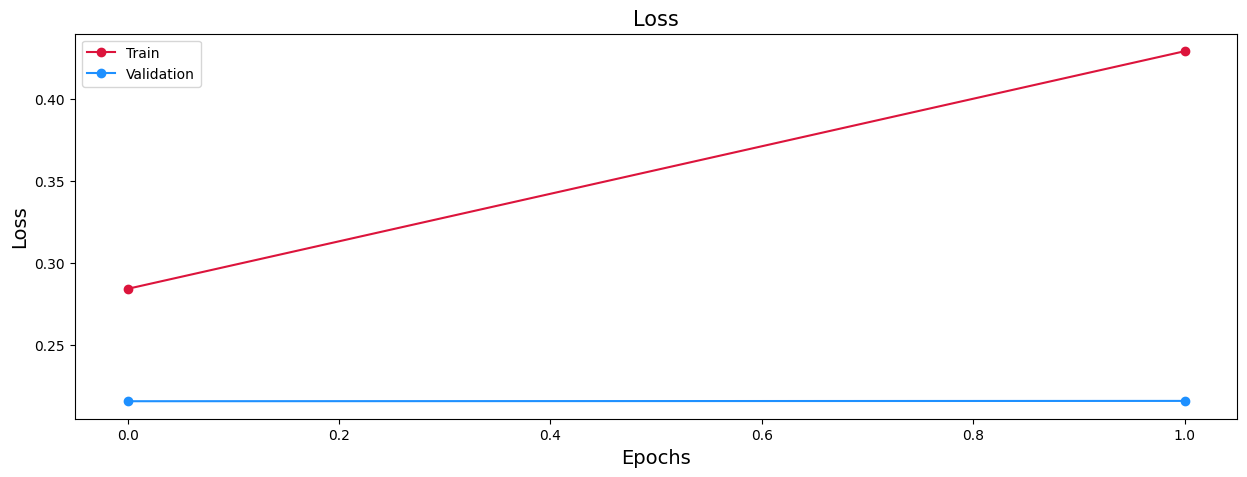

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
plt.show()

## Reload the model

In [27]:
from tensorflow.train import latest_checkpoint

reloaded_model = create_model(optimizer)
# reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
reloaded_model.load_weights('model_weights/weights.h5')
reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                         

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, rankdir='LR', dpi=52)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Prediction

In [35]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 3],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 2, 2, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

## Predict on test data

In [36]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)

In [37]:
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category},{sentiment}')

In [39]:
y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

25/25 [==============================] - 194s 8s/step - loss: 0.3548


0.3547845780849457

In [41]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = df_test.columns[1:]
print_acsa_pred(replacements, categories, y_pred[0])

=> FOOD#QUALITY,positive
=> FOOD#STYLE&OPTIONS,positive


## Predict random text

In [44]:
example_input = preprocessing_text(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}


pred = predict(reloaded_model, Dataset.from_tensor_slices(features))
print_acsa_pred(replacements, categories, pred[0])

=> FOOD#QUALITY,positive


# Report metrics

## Aspect Detection

In [45]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [46]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

                          precision    recall  f1-score   support

                             0.6927    0.9606    0.8050      3581
        AMBIENCE#GENERAL     1.0000    0.0000    0.0000       255
           DRINKS#PRICES     1.0000    0.0000    0.0000        76
          DRINKS#QUALITY     1.0000    0.0000    0.0000        71
    DRINKS#STYLE&OPTIONS     1.0000    0.0000    0.0000        46
             FOOD#PRICES     0.8049    0.0997    0.1774       331
            FOOD#QUALITY     0.9140    1.0000    0.9551       457
      FOOD#STYLE&OPTIONS     0.8174    1.0000    0.8996       403
        LOCATION#GENERAL     1.0000    0.0000    0.0000       179
      RESTAURANT#GENERAL     1.0000    0.0000    0.0000       223
RESTAURANT#MISCELLANEOUS     1.0000    0.0000    0.0000       130
       RESTAURANT#PRICES     1.0000    0.0000    0.0000        73
         SERVICE#GENERAL     1.0000    0.0000    0.0000       175

                accuracy                         0.7222      6000
        

## Polarity Detection

In [47]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))

In [48]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.6927    0.9606    0.8050      3581
    positive     0.7422    0.4416    0.5537      1669
    negative     0.0000    0.0000    0.0000       159
     neutral     0.5854    0.0406    0.0759       591

    accuracy                         0.7002      6000
   macro avg     0.5051    0.3607    0.3587      6000
weighted avg     0.6775    0.7002    0.6419      6000



c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nguyen Quang Tu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Aspect + Polarity

In [49]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [50]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                                   precision    recall  f1-score   support

            AMBIENCE#GENERAL,None     0.4900    1.0000    0.6577       245
        AMBIENCE#GENERAL,negative     1.0000    0.0000    0.0000        26
         AMBIENCE#GENERAL,neutral     1.0000    0.0000    0.0000        48
        AMBIENCE#GENERAL,positive     1.0000    0.0000    0.0000       181
               DRINKS#PRICES,None     0.8480    1.0000    0.9177       424
           DRINKS#PRICES,negative     1.0000    0.0000    0.0000         3
            DRINKS#PRICES,neutral     1.0000    0.0000    0.0000        45
           DRINKS#PRICES,positive     1.0000    0.0000    0.0000        28
              DRINKS#QUALITY,None     0.8580    1.0000    0.9236       429
          DRINKS#QUALITY,negative     1.0000    0.0000    0.0000         6
           DRINKS#QUALITY,neutral     1.0000    0.0000    0.0000        11
          DRINKS#QUALITY,positive     1.0000    0.0000    0.0000        54
        DRINKS#STYLE&OPT

## Summary

In [51]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [52]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.940695,0.235409,0.218231,0.722167
Polarity Detection,0.505068,0.360704,0.358657,0.700167
Aspect + Polarity,0.915909,0.253374,0.209904,0.700167


# Export to VLSP format

In [ ]:
vlsp_results = []
for index, pred in enumerate(y_pred):
    sentiments = map(lambda x: replacements[x], pred)
    result = {
        'id': f'#{index + 1}',
        'text': df_test.Review[index],
        'acsa': []
    }
    for category, sentiment in zip(categories, sentiments):
        if sentiment: result['acsa'].append('{'+ category + ', ' + sentiment + '}')
    vlsp_results.append(result)
vlsp_results[:3]

[{'acsa': ['{ROOM_AMENITIES#CLEANLINESS, negative}',
   '{ROOMS#CLEANLINESS, negative}',
   '{SERVICE#GENERAL, negative}'],
  'id': '#1',
  'text': 'Ga giường không sạch, nhân viên quên dọn phòng một ngày.'},
 {'acsa': ['{LOCATION#GENERAL, positive}',
   '{ROOMS#CLEANLINESS, positive}',
   '{ROOMS#COMFORT, positive}',
   '{SERVICE#GENERAL, positive}'],
  'id': '#2',
  'text': 'Nv nhiệt tình, phòng ở sạch sẽ, tiện nghi, vị trí khá thuận tiện cho việc di chuyển đến các địa điểm ăn + chơi Phòng có gián'},
 {'acsa': ['{LOCATION#GENERAL, positive}',
   '{ROOMS#DESIGN&FEATURES, neutral}',
   '{ROOMS#GENERAL, positive}'],
  'id': '#3',
  'text': 'Đi bộ ra biển gần, tiện đi lại Phòng view biển nhưng cửa sổ view biển khá bé'}]